Progress Report 1
----

**Team Members**

Yaqian Cheng, Department of Statistical Science

Mengrun Li, Department of Statistical Science

**Github repository**

<https://github.com/cici7941/Sta_663_Statistical_Computation_Final_Project>

**Choice of paper** 

*Scalable K-Means++*

**Abstract**

*K-means* is one of the most popular clustering methods. A good initialization of *k-means* is essential for obtaining the global optimal solution and efficiency. However, there are two main obstacles with traditional *k-means* method. One is theoretical inefficiency and the other one is that its final solution is locally optimal. A better algorithm, *k-means++* addresses the second problem with an improved initialization procedure of the cluster centers. But this *k-means++* initialization is not parallelizable, because the selection for the *i*th center depends on the previous *i-1* centers [1]. Therefore, *k-means||*, a parallelizable version of *k-means++*, has been raised, which can both improve the final solution and run faster. In this report, we implemented the algorithm in the paper "Scalable K-Means++" in Python, compared the clustering cost and runtime between *k-means*, *k-means++* and *k-means||*, performed tests for main functions, profiled the performance of the algorithm and identified bottlenecks, and performed optimization using Cython. We then apply *k-means||* to a massive dataset to evaluate its performance.

**Outline**

1. Introduction
2. Algorithm  
    2.1 K-Means  
    2.2 K-Means++  
    2.3 K-Means||  
3. Code Testing
4. Profiling and Optimization
5. Application and Comparison

In [31]:
import scipy.linalg as la
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from numba import jit, njit

In [8]:
# helper functions
def euc_dist(x, y):
    return la.norm(x-y)

def centroid(X):
    return X.mean(0)
    
def d(x, Y):
    minDist = float("inf")
    for yi in Y:
        dist = euc_dist(x, yi)
        if(dist < minDist):
            minDist = dist
    return minDist

def cost(Y, C):
    cost = 0
    for yi in Y:
        cost += d(yi, C)**2
    return cost

**Algorithm 1** *k-means++(k)* initialization 
1. $C$ $\leftarrow$ sample a point uniformly at random from $X$  
2. **while** |$C$| < $k$ **do**
3. $\,\,$ Sample $x$ \in $X$ with probability $\frac{d^2(x,C}{\psi_X(C)}$
4. $\,\,$ $C$ $\leftarrow$ $C$ $\cup$ $\{x\}$
5. **end while**

In [9]:
# K-Means++
def kmeans_plus(data, k):
    idx = np.random.choice(data.shape[0], 1)
    C = data[idx, :]
    while(C.shape[0] < k):
        prob = list(map(lambda xi: d(xi,C)**2/cost(data,C), data))
        Ct = data[np.random.choice(data.shape[0], size=1, p=prob),:]
        if(Ct.tolist() not in C.tolist()):
            C = np.r_[C, Ct]
    return C

**Initialization algorithm: k-means||**  
*k-means||* uses an oversampling factor *l* = $\Omega$(k), which is unlike *k-means++*. Intuitively, *l* should be thought of as $\Theta$(k). This initialization algorithm picks an initial center uniformly from the dataset and computes $\psi$, here is initial cost of the clustering of this selection. Then do log$\psi$ iterations and in each iteration, it samples each x with probability *l*$d^2(x,C)/\psi_X(C)$ given current set C of centers. If the point is sampled, it will be added to C and the quantity $\phi_X(C)$ updated and interation continued. The expected number of points chosen in each iteration is l. Since there is oversampling factor, thus the number of points in C will be more than k. To reduce the number of centers, weight each point in C by the number of points in X whose distance to this point is shorter than it of any other point in C. And then recluster the weighted points to obtain k centers.

**Algorithm 2** *k-means||(k,l)* initialization  
1. $C$ $\leftarrow$ sample a point uniformly at random from $X$  
2. $\psi$ $\leftarrow$ $\phi_X(C)$  
3. **for** O(log$\psi$) times **do**  
      $\,\,$ $C'$ $\leftarrow$ sample each point $x \in X$ independently with probability $p_x = \frac{l*d^2(x,C)}{\phi_X(C)}$  
      $\,\,$ $C$ $\leftarrow$ $C$ $\cup$ $C'$  
   **end for**  
4. For x $\in$ $C$, set $w_x$ to be the number of points in X closer to x than any other point in C  
5. Recluster the weighted points in C into k clusters

In [67]:
Ct=np.empty([0,data.shape[1]])

In [72]:
Ct.shape

(0, 3)

In [74]:
data[1,:].shape

(3,)

(1, 3)

In [80]:
#helper function for scalable k-means++ sampling
def scalable_kmeans_sample(X, C, cost_X):
    Ct = np.empty([0,X.shape[1]])
    prob = list(map(lambda x:l*d(x,C)**2/cost_X, X))
    for j in range(len(X)):
            if(prob[j] > 1):
                point = 1
            else:
                point = np.random.binomial(1,prob[j],size = 1)
            if point == 1 and (X[j,:].tolist() not in C.tolist()):
                Ct = np.r_[Ct, [X[j,:]]]
    return np.r_[C, Ct]

In [ ]:
#helper function for scalable k-means++ weighting
def weight(X,C):
    w = []
    for c in C:
        distxc = map(lambda x: euc_dist(x,c), X)
        distc = list(map(lambda y: euc_dist(y,c), C))
        distc.remove(0)
        count = len(list(filter(lambda p: p < min(distc), distxc)))
        w.append(count)
    return w

In [81]:
###K-means|| speed up
def scalable_kmeans_plus(X, k, l):
    ##Sample a point uniformly at random from X
    idx = np.random.choice(X.shape[0],1,replace = False)
    C = X[idx,:]
    for i in range(int(round(np.log(gamma1)))):
        cost_X = cost(X,C)
        if(cost_X == 0):
            break
        C = scalable_kmeans_sample(X, C, cost_X)
    w = weight(X,C)
    w_prob = w/np.sum(w)
    centroid = np.random.choice(range(C.shape[0]),k,p = w_prob,replace = False)
    return C[centroid]

In [34]:
%%time
kmeans_plus(data,3)

CPU times: user 4.14 s, sys: 23.2 ms, total: 4.16 s
Wall time: 4.18 s


array([[  2.3449445 ,   4.89867136,   1.        ],
       [ -2.59043915,   6.20593556,   1.        ],
       [ 13.10647296,   5.7411968 ,   3.        ]])

In [88]:
%%time
scalable_kmeans_plus(data, 3, 2)

CPU times: user 667 ms, sys: 2.57 ms, total: 670 ms
Wall time: 670 ms


array([[ 0.33801858,  5.28524022,  1.        ],
       [ 7.82666913,  3.01403277,  2.        ],
       [ 2.43124311,  5.26896312,  1.        ]])

In [15]:
# K-Means||
X_ori = np.random.normal(10,1,(300,10))
X = X_ori
k = 3
l = 2
##step1
##Sample a point uniformly at random from X
idx1 = np.random.choice(X_ori.shape[0],1,replace = False)
C = X[idx1,:]
print(idx1)
print("first centroid:",C)
##step2
##initial cost
gamma1 = cost(X,C)
print("initial cost:",gamma1)
##remove first centroid
X.shape

[233]
first centroid: [[  9.20207175  10.7185761    9.15098145   9.9381587    9.816011
    9.58961692   7.95512539   9.95636515   8.35340917   7.36418056]]
initial cost: 7975.765095867941


(300, 10)

In [111]:
##step3-6
for i in range(int(round(np.log(gamma1)))):
    Ct = []
    idx = []
    gamma = cost(X,C)
    if(gamma == 0):
        break
    prob = [l*d(x,C)**2/gamma for x in X]
    #new = data[np.random.choice(X.shape[0], size=1, p=prob),:]
    for j in range(len(X)):
        if(prob[j] > 1):
            point = 1
        else:
            point = np.random.binomial(1,prob[j],size = 1)
        if point == 1 and (X[j,:].tolist() not in C.tolist()):
           Ct.append(X[j,:])
           idx.append(j)
    C = np.concatenate((C,np.array(Ct).reshape(len(Ct),C.shape[1])),axis = 0)

array([[  9.5460608 ,  10.37481709,   9.8905099 ,   9.67666977,
         10.7555565 ,   8.52968755,   8.80848133,  10.87739795,
         11.40538468,   7.72921769],
       [ 10.06378486,   9.99090206,   8.91035612,   9.78660917,
         10.57575838,   9.56740964,  11.54121504,   9.65060648,
          8.58687934,  10.20249724],
       [  8.85773088,  10.88477589,   9.95852294,   8.60613374,
          7.62688839,   8.92964673,  11.43489616,   8.4165022 ,
          8.21098795,   8.51515683],
       [  9.71974919,   9.56647842,  10.09740474,   8.02167727,
          8.57156626,   9.47213862,   9.6737486 ,  10.597333  ,
          9.28289429,  11.27897   ],
       [ 10.74944557,   8.2253346 ,  10.76994475,   9.01329841,
          9.14418031,  10.60185343,  10.60254169,   8.76339033,
          7.90641973,   7.46455916],
       [ 10.71204685,  10.11942413,  11.26601015,   7.72744965,
         10.74372474,   9.88368874,   7.79986843,   8.99542979,
          8.4107155 ,  11.04149347],
       [ 1

In [112]:
##step7
w = []
for c in C:
    distxc = map(lambda x: euc_dist(x,c), X)
    distc = list(map(lambda y: euc_dist(y,c), C))
    distc.remove(0)
    count = 0
    for p in distxc:
        if p < min(distc):
           count += 1
    w.append(count)
w

[11, 46, 17, 9, 6, 9, 13, 14, 3, 8, 27, 52, 100, 20, 6, 23, 4, 20, 52]

In [118]:
##step8
w_prob = w/np.sum(w)
w_prob
centroid = np.random.choice(range(C.shape[0]),k,p = w_prob,replace = False)
C[centroid]

array([[ 10.20043272,  10.22790724,  11.10836724,   9.22225105,
          9.52146593,   9.74006505,  10.08196538,   9.1795259 ,
         10.69665102,   7.90604362],
       [ 10.06378486,   9.99090206,   8.91035612,   9.78660917,
         10.57575838,   9.56740964,  11.54121504,   9.65060648,
          8.58687934,  10.20249724],
       [ 11.22460917,  10.36975348,   9.03873432,  11.13497719,
         10.37626561,   9.44677934,   8.21615445,  11.49745789,
          9.95857798,   9.94206058]])

In [5]:
##k-means||
def kmeansparallel1(X_ori,k,l):
    X = X_ori
    ##Sample a point uniformly at random from X
    idx1 = np.random.choice(X_ori.shape[0],1,replace = False)
    C = X[idx1,:]
    ##remove first centroid
    #X = np.delete(X, idx1, axis=0)
    for i in range(int(round(np.log(cost(X,C))))):
        Ct = []
        idx = []
        gamma = cost(X,C)
        if(gamma == 0):
            break
        prob = [l*d(x,C)**2/cost(X,C) for x in X]
        for j in range(len(X)):
            if(prob[j] > 1):
                point = 1
            else:
                point = np.random.binomial(1,prob[j],size = 1)
            if point == 1:
               Ct.append(X[j,:])
               idx.append(j)
        X = np.delete(X, idx, axis = 0)
        C = np.concatenate((C,np.array(Ct).reshape(len(Ct),C.shape[1])),axis = 0)
    ##step8
    w = weight(X,C)
    w_prob = w/np.sum(w)
    centroid = np.random.choice(range(C.shape[0]),k,p = w_prob,replace = False)
    return C[centroid]

In [25]:
###K-means|| speed up
def scalable_kmeans_plus(X, k, l):
    ##Sample a point uniformly at random from X
    idx = np.random.choice(X.shape[0],1,replace = False)
    C = X[idx,:]
    for i in range(int(round(np.log(gamma1)))):
        cost_X = cost(X,C)
        if(cost_X == 0):
            break
        C = scalable_kmeans_sample(X, C, cost_X)
    w = weight(X,C)
    w_prob = w/np.sum(w)
    centroid = np.random.choice(range(C.shape[0]),k,p = w_prob,replace = False)
    return C[centroid]

In [16]:
%%time
kmeansparallel1(X_ori,k,l)

NameError: name 'kmeansparallel1' is not defined

In [29]:
%%time
scalable_kmeans_plus(X,k,l)

CPU times: user 426 ms, sys: 6.28 ms, total: 432 ms
Wall time: 432 ms


array([[ 10.49354882,   9.9904693 ,  10.08451009,  10.11806325,
         11.46240864,   9.01213735,   9.24351641,   9.97570911,
         11.73358549,   7.9480531 ],
       [  9.37033573,  10.92352793,  10.91292803,   9.06772495,
         10.37862036,  10.1563294 ,  10.859663  ,  11.0480878 ,
          9.76247345,   9.93289685],
       [  9.05669229,  10.09033202,   9.99143008,   9.3541883 ,
         10.69376317,   9.69735627,   9.2070343 ,   9.22563777,
          8.86548422,  12.62933874]])

### Simulating Data

In [32]:
n = 100
mu1 = np.array([2, 6])
cov1 = np.array([[2, 0.5], [0.5, 2]])
subset1 = np.random.multivariate_normal(mu1, cov1, n)
subset1 = np.c_[subset1,np.ones(n)]

mu2 = np.array([5, 2])
cov2 = np.array([[2, 0.5], [0.5, 2]])
subset2 = np.random.multivariate_normal(mu2, cov2, n)
subset2 = np.c_[subset2,np.ones(n)+1]

mu3 = np.array([12, 5])
cov3 = np.array([[2, 1], [1, 2]])
subset3 = np.random.multivariate_normal(mu3, cov3, n)
subset3 = np.c_[subset3,np.ones(n)+2]

data = np.r_[subset1, subset2, subset3]
np.random.shuffle(data)

In [13]:
%%time
init = kmeansPlus(data[:,0:2], 3)

CPU times: user 3.9 s, sys: 5.41 ms, total: 3.9 s
Wall time: 3.91 s


In [12]:
%%time
init = kmeansparallel(data[:,0:2], 3, 2)

CPU times: user 539 ms, sys: 5.37 ms, total: 544 ms
Wall time: 547 ms


In [147]:
y_pred_kmeans = KMeans(n_clusters=3,init = init,n_init=1).fit_predict(data[:,0:2])

In [148]:
y_pred_kmeans = KMeans(n_clusters=3,init = "random").fit_predict(data[:,0:2])
y_pred_kmeans_plus = KMeans(n_clusters=3,init = "k-means++").fit_predict(data[:,0:2])
y_pred_kmeans_plus_scalable = KMeans(n_clusters=3,init = init,n_init=1).fit_predict(data[:,0:2])

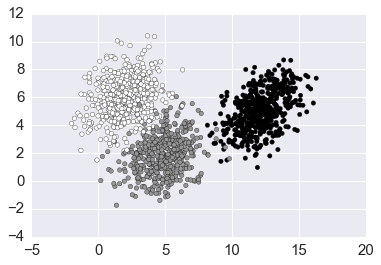

In [149]:
plt.scatter(data[:,0], data[:,1], c=data[:,2])

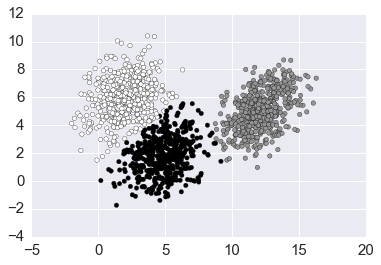

In [150]:
plt.scatter(data[:,0], data[:,1], c=y_pred_kmeans);

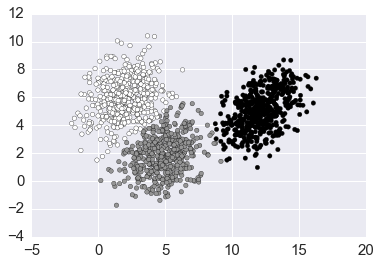

In [151]:
plt.scatter(data[:,0], data[:,1], c=y_pred_kmeans_plus);

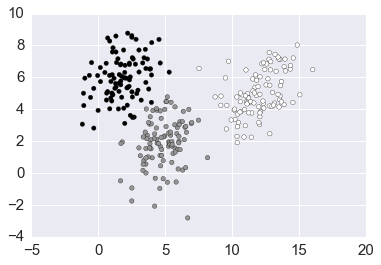

In [93]:
plt.scatter(data[:,0], data[:,1], c=y_pred_kmeans_plus_scalable);